In [1]:
import numpy as np
import os, sys
import xarray as xr
import pandas as pd
from scipy.ndimage import binary_erosion
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import colorcet as cc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
start_datetime = '2016-08-10T00'
end_datetime = '2016-08-11T00'
map_extent = [125.0, 165.0, 10.0, 30.0]
phase = 'Summer'
runname = 'OBS'
tracker = 'PyFLEXTRKR'
# tracker = 'TOOCAN'
# tracker = 'MOAAP'
# tracker = 'tobac'
# tracker = 'TAMS'
# tracker = 'simpleTrack'

fig_dir = '/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/'
figdir = f'{fig_dir}{phase}/quicklooks/animations/'

subset = 1
buffer = 0

root_path = '/pscratch/sd/f/feng045/DYAMOND/'
# stats_path = f'{root_path}/mcs_stats/{phase}/{tracker}/'
mask_path = f'{root_path}/mcs_mask/{phase}/{tracker}/'
olr_path = f'{root_path}OLR_Precipitation_combined/'
mcsstats_filebase = 'mcs_stats_'
mcsmask_filebase = 'mcs_mask_'
olr_filebase = 'olr_pcp_'
# trackstats_file = f"{stats_path}{mcsstats_filebase}{phase}_{runname}.nc"
mask_file = f"{mask_path}{mcsmask_filebase}{phase}_{runname}.nc"
olr_file = f"{olr_path}{olr_filebase}{phase}_{runname}.nc"

In [3]:
figdir

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/quicklooks/animations/'

In [4]:
mask_file, olr_file

('/pscratch/sd/f/feng045/DYAMOND//mcs_mask/Summer/PyFLEXTRKR/mcs_mask_Summer_OBS.nc',
 '/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined/olr_pcp_Summer_OBS.nc')

In [37]:
#--------------------------------------------------------------------------
def olr_to_tb(OLR):
    """
    Convert OLR to IR brightness temperature.

    Args:
        OLR: np.array
            Outgoing longwave radiation
    
    Returns:
        tb: np.array
            Brightness temperature
    """
    # Calculate brightness temperature
    # (1984) as given in Yang and Slingo (2001)
    # Tf = tb(a+b*Tb) where a = 1.228 and b = -1.106e-3 K^-1
    # OLR = sigma*Tf^4 
    # where sigma = Stefan-Boltzmann constant = 5.67x10^-8 W m^-2 K^-4
    a = 1.228
    b = -1.106e-3
    sigma = 5.67e-8 # W m^-2 K^-4
    tf = (OLR/sigma)**0.25
    tb = (-a + np.sqrt(a**2 + 4*b*tf))/(2*b)
    return tb

#--------------------------------------------------------------------------
def make_dilation_structure(dilate_radius, dx, dy):
    """
    Make a circular dilation structure

    Args:
        dilate_radius: float
            Dilation radius [kilometer].
        dx: float
            Grid spacing in x-direction [kilometer].
        dy: float
            Grid spacing in y-direction [kilometer]. 
    
    Returns:
        struc: np.array
            Dilation structure array.
    """
    # Convert radius to number grids
    rad_gridx = int(dilate_radius / dx)
    rad_gridy = int(dilate_radius / dy)
    xgrd, ygrd = np.ogrid[-rad_gridx:rad_gridx+1, -rad_gridy:rad_gridy+1]
    # Make dilation structure
    strc = xgrd*xgrd + ygrd*ygrd <= (dilate_radius / dx) * (dilate_radius / dy)
    return strc

#-----------------------------------------------------------------------
def label_perimeter(tracknumber, dilationstructure):
    """
    Labels the perimeter on a 2D map from object tracknumber masks.
    """
    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)

    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)

    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the track mask
        itn = tracknumber == ii
        # Erode the mask by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the track number
        tracknumber_perim[iperim == 1] = ii

    return tracknumber_perim

In [6]:
# Read OLR/precipitation file, subset to input datetime range
dso = xr.open_dataset(olr_file).sel(time=slice(start_datetime, end_datetime))

# Read MCS mask file, subset to intput datetime range
dsm = xr.open_dataset(mask_file).sel(time=slice(start_datetime, end_datetime))

nt_dso = dso.dims['time']
nt_dsm = dsm.dims['time']

# Replace the lat/lon coordinates
if nt_dso == nt_dsm:
    dsm = dsm.assign_coords({'time':dso['time'], 'lon':dso['lon'], 'lat':dso['lat']})
else:
    print(f'ERROR: number of subset times not the same between OLR/PCP and MCS mask files!')
    # print(f'Code will exit now.')
    # sys.exit()

if runname != 'OBS':
    # Convert OLR to Tb
    tb = olr_to_tb(dso['olr'])
    # Add Tb to DataSet
    dso['Tb'] = tb
    
# Combine OLR/precipitation and MCS mask DataSets
ds = xr.combine_by_coords([dsm, dso], combine_attrs='drop_conflicts')

In [7]:
# # Make a dilation structure
# dilationstructure = make_dilation_structure(perim_thick, pixel_radius, pixel_radius)
# plot_info['dilationstructure'] = dilationstructure

# Get tracknumbers
# tn = ds['mcs_mask'].squeeze()

# Subset pixel data within the map domain        
if subset == 1:            
    lonmin, lonmax = map_extent[0]-buffer, map_extent[1]+buffer
    latmin, latmax = map_extent[2]-buffer, map_extent[3]+buffer
    mask = (ds['longitude'] >= lonmin) & (ds['longitude'] <= lonmax) & \
           (ds['latitude'] >= latmin) & (ds['latitude'] <= latmax)
    ds_sub = ds.where(mask == True, drop=True)
    # ds_sub = ds.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
else:
    ds_sub = ds

In [8]:
ds_sub

<xarray.Dataset>
Dimensions:                 (time: 25, lat: 200, lon: 400)
Coordinates:
  * lat                     (lat) float64 10.05 10.15 10.25 ... 29.85 29.95
  * lon                     (lon) float64 125.1 125.1 125.2 ... 164.8 164.9
  * time                    (time) datetime64[ns] 2016-08-10 ... 2016-08-11
Data variables:
    Tb                      (time, lat, lon) float32 262.5 268.7 ... 292.8 292.5
    precipitation           (time, lat, lon) float32 0.004341 0.0 ... 0.0 0.0
    cloud_mask              (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_mask_no_mergesplit  (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_mask                (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    longitude               (lat, lon) float64 125.1 125.1 125.2 ... 164.8 164.9
    latitude                (lat, lon) float64 10.05 10.05 10.05 ... 29.95 29.95
Attributes:
    phase:    Summer
    source:   OBS
    tracker:  PyFLEXTRKR
    Contact:  Zhe Feng, zhe.feng@pnnl.gov

In [9]:
ny = ds_sub.sizes['lat']
nx = ds_sub.sizes['lon']
ntime = ds_sub.sizes['time']
lon = ds_sub['lon']
lat = ds_sub['lat']
lat2d = ds_sub['latitude']
lon2d = ds_sub['longitude']
mcs_mask = ds_sub['mcs_mask'].load()
mcs_mask

In [11]:
# Get unique track numbers
uniq_mcs_tracks, n_uniq_pix = np.unique(mcs_mask, return_counts=True)
# Remove 0 & NaN (not a track)
idx_valid = (uniq_mcs_tracks != 0) & (~np.isnan(uniq_mcs_tracks))
uniq_mcs_tracks = uniq_mcs_tracks[idx_valid]
n_uniq_pix = n_uniq_pix[idx_valid]
ntracks_pix = len(uniq_mcs_tracks)

uniq_mcs_tracks, n_uniq_pix

(array([ 757.,  814.,  921.,  931.,  945.,  947.,  952.,  960.,  964.,
         980.,  986.,  994.,  997., 1021., 1025., 1026., 1043., 1053.,
        1057., 1059., 1114.]),
 array([ 23641,   1547,  12245,   2336,  22550,   4657,   1416, 157593,
         23062,   1213,   6817,      8,  56174, 118578,    102,   1079,
             9,   7414,      2,     14,   6467]))

In [48]:
# Make a dilation structure
perim_thick = 10
pixel_radius = 10
dilationstructure = make_dilation_structure(perim_thick, pixel_radius, pixel_radius)
dilationstructure

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [49]:
mask_swath = np.full((ntracks_pix, ny, nx), 0, dtype=int)
mask_perim = np.full((ntracks_pix, ny, nx), 0, dtype=int)
count_swath = np.full((ny, nx), 0, dtype=int)
tracks_lat = np.full((ntracks_pix, ntime), np.NaN, dtype=float)
tracks_lon = np.full((ntracks_pix, ntime), np.NaN, dtype=float)

for ii in range(ntracks_pix):
    # Find the specific track mask, sum over time to get the swath
    iswath = (mcs_mask == uniq_mcs_tracks[ii]).sum(dim='time')
    count_swath[:,:] += iswath.data
    # Replace the swath area with a number
    mask_swath[ii,:,:] = iswath.where(iswath == 0, other=ii+1).data
    # Get swath perimeter
    mask_perim[ii,:,:] = label_perimeter(mask_swath[ii,:,:].squeeze(), dilationstructure)
    
    # Find specific track mask, average over space to get the mean lat/lon location time series
    tracks_lat[ii,:] = lat2d.where(mcs_mask == uniq_mcs_tracks[ii]).mean(dim=('lat','lon')).data
    tracks_lon[ii,:] = lon2d.where(mcs_mask == uniq_mcs_tracks[ii]).mean(dim=('lat','lon')).data
    
    print(ii, uniq_mcs_tracks[ii], n_uniq_pix[ii])

0 757.0 23641
1 814.0 1547
2 921.0 12245
3 931.0 2336
4 945.0 22550
5 947.0 4657
6 952.0 1416
7 960.0 157593
8 964.0 23062
9 980.0 1213
10 986.0 6817
11 994.0 8
12 997.0 56174
13 1021.0 118578
14 1025.0 102
15 1026.0 1079
16 1043.0 9
17 1053.0 7414
18 1057.0 2
19 1059.0 14
20 1114.0 6467


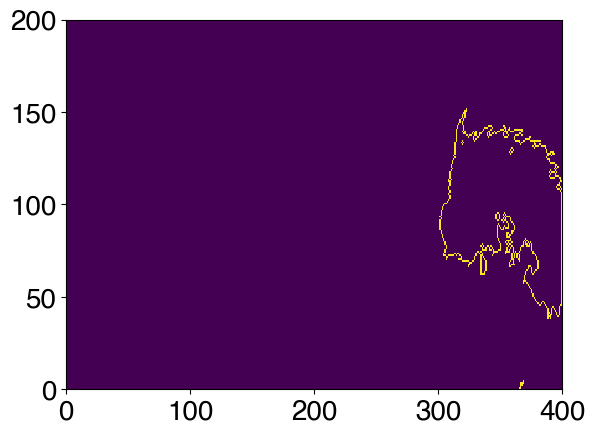

In [51]:
# np.count_nonzero(mask_perim[1,:,:] > 0)
plt.pcolormesh(mask_perim[0,:,:])

In [32]:
# ii = 6
# plt.plot(tracks_lon[ii,:], tracks_lat[ii,:])
# s_idx = np.argmax(~np.isnan(tracks_lon[ii,:]))
# plt.scatter(tracks_lon[ii,s_idx], tracks_lat[ii,s_idx], s=20, zorder=10, facecolor='red')

In [33]:
# ii = 10
# print(tracks_lon[ii,:])
# # print(np.nanargmin(tracks_lon[ii,:]))
# np.argmax(~np.isnan(tracks_lon[ii,:]))

In [34]:
# # tracks_lon[ii,:].shape
# np.where(~np.isnan(tracks_lon[ii,:]))[0][0]

In [35]:
# for ii in range(ntracks_pix):
#     print(tracks_lon[ii,:])
#     # np.nanargmin(tracks_lat[ii,:])

In [36]:
# tracks_lon[:,0], tracks_lat[:,0]

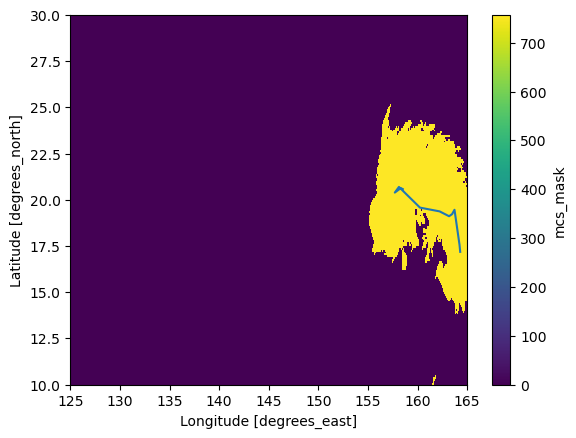

In [20]:
iswath = (mcs_mask == uniq_mcs_tracks[0]).sum(dim='time')
iswath.where(iswath == 0, other=uniq_mcs_tracks[0]).plot()
plt.plot(tracks_lon[0,:], tracks_lat[0,:])

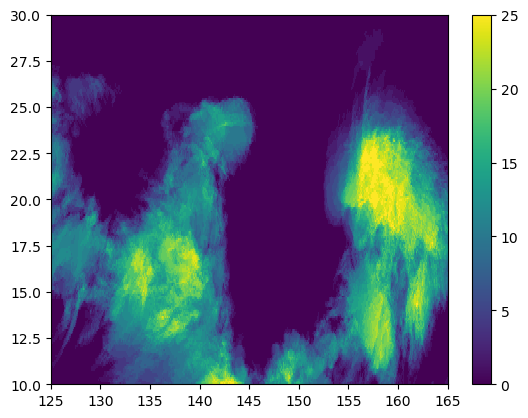

In [21]:
plt.pcolormesh(lon, lat, count_swath)
plt.colorbar()
# plt.plot(tracks_lon[0,:], tracks_lat[0,:])

## Example plot

In [22]:
# Determine the figsize based on lat/lon ratio
figsize = None
if (figsize is None):
    # If map_extent is specified, calculate aspect ratio
    if (map_extent is not None):
        # Get map aspect ratio from map_extent (minlon, maxlon, minlat, maxlat)
        lon_span = map_extent[1] - map_extent[0]
        lat_span = map_extent[3] - map_extent[2]
        fig_ratio_yx = lat_span / lon_span

        figsize_x = 12
        figsize_y = figsize_x * fig_ratio_yx
        figsize_y = float("{:.2f}".format(figsize_y))  # round to 2 decimal digits
        figsize = [figsize_x, figsize_y]
    else:
        figsize = [10, 10]
        
map_resolution = '50m'
draw_border = False
draw_state = False
fontsize = 10
dpi = 300
map_edgecolor = 'k'

titles = f'{runname} [{tracker}]'
figbasename_mask = f'{phase}_{runname}_{tracker}_swathmask_'
figbasename_count = f'{phase}_{runname}_{tracker}_count_'
fdatetime = f'{start_datetime}_{end_datetime}'
figname_mask = f'{figdir}{figbasename_mask}{fdatetime}.png'
figname_count = f'{figdir}{figbasename_count}{fdatetime}.png'
figname_cb = f'{figdir}colorbar_count_horizontal.png'
figname_mask, figname_count, figname_cb

('/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/quicklooks/animations/Summer_OBS_PyFLEXTRKR_swathmask_2016-08-10T00_2016-08-11T00.png',
 '/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/quicklooks/animations/Summer_OBS_PyFLEXTRKR_count_2016-08-10T00_2016-08-11T00.png',
 '/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/quicklooks/animations/colorbar_count_horizontal.png')

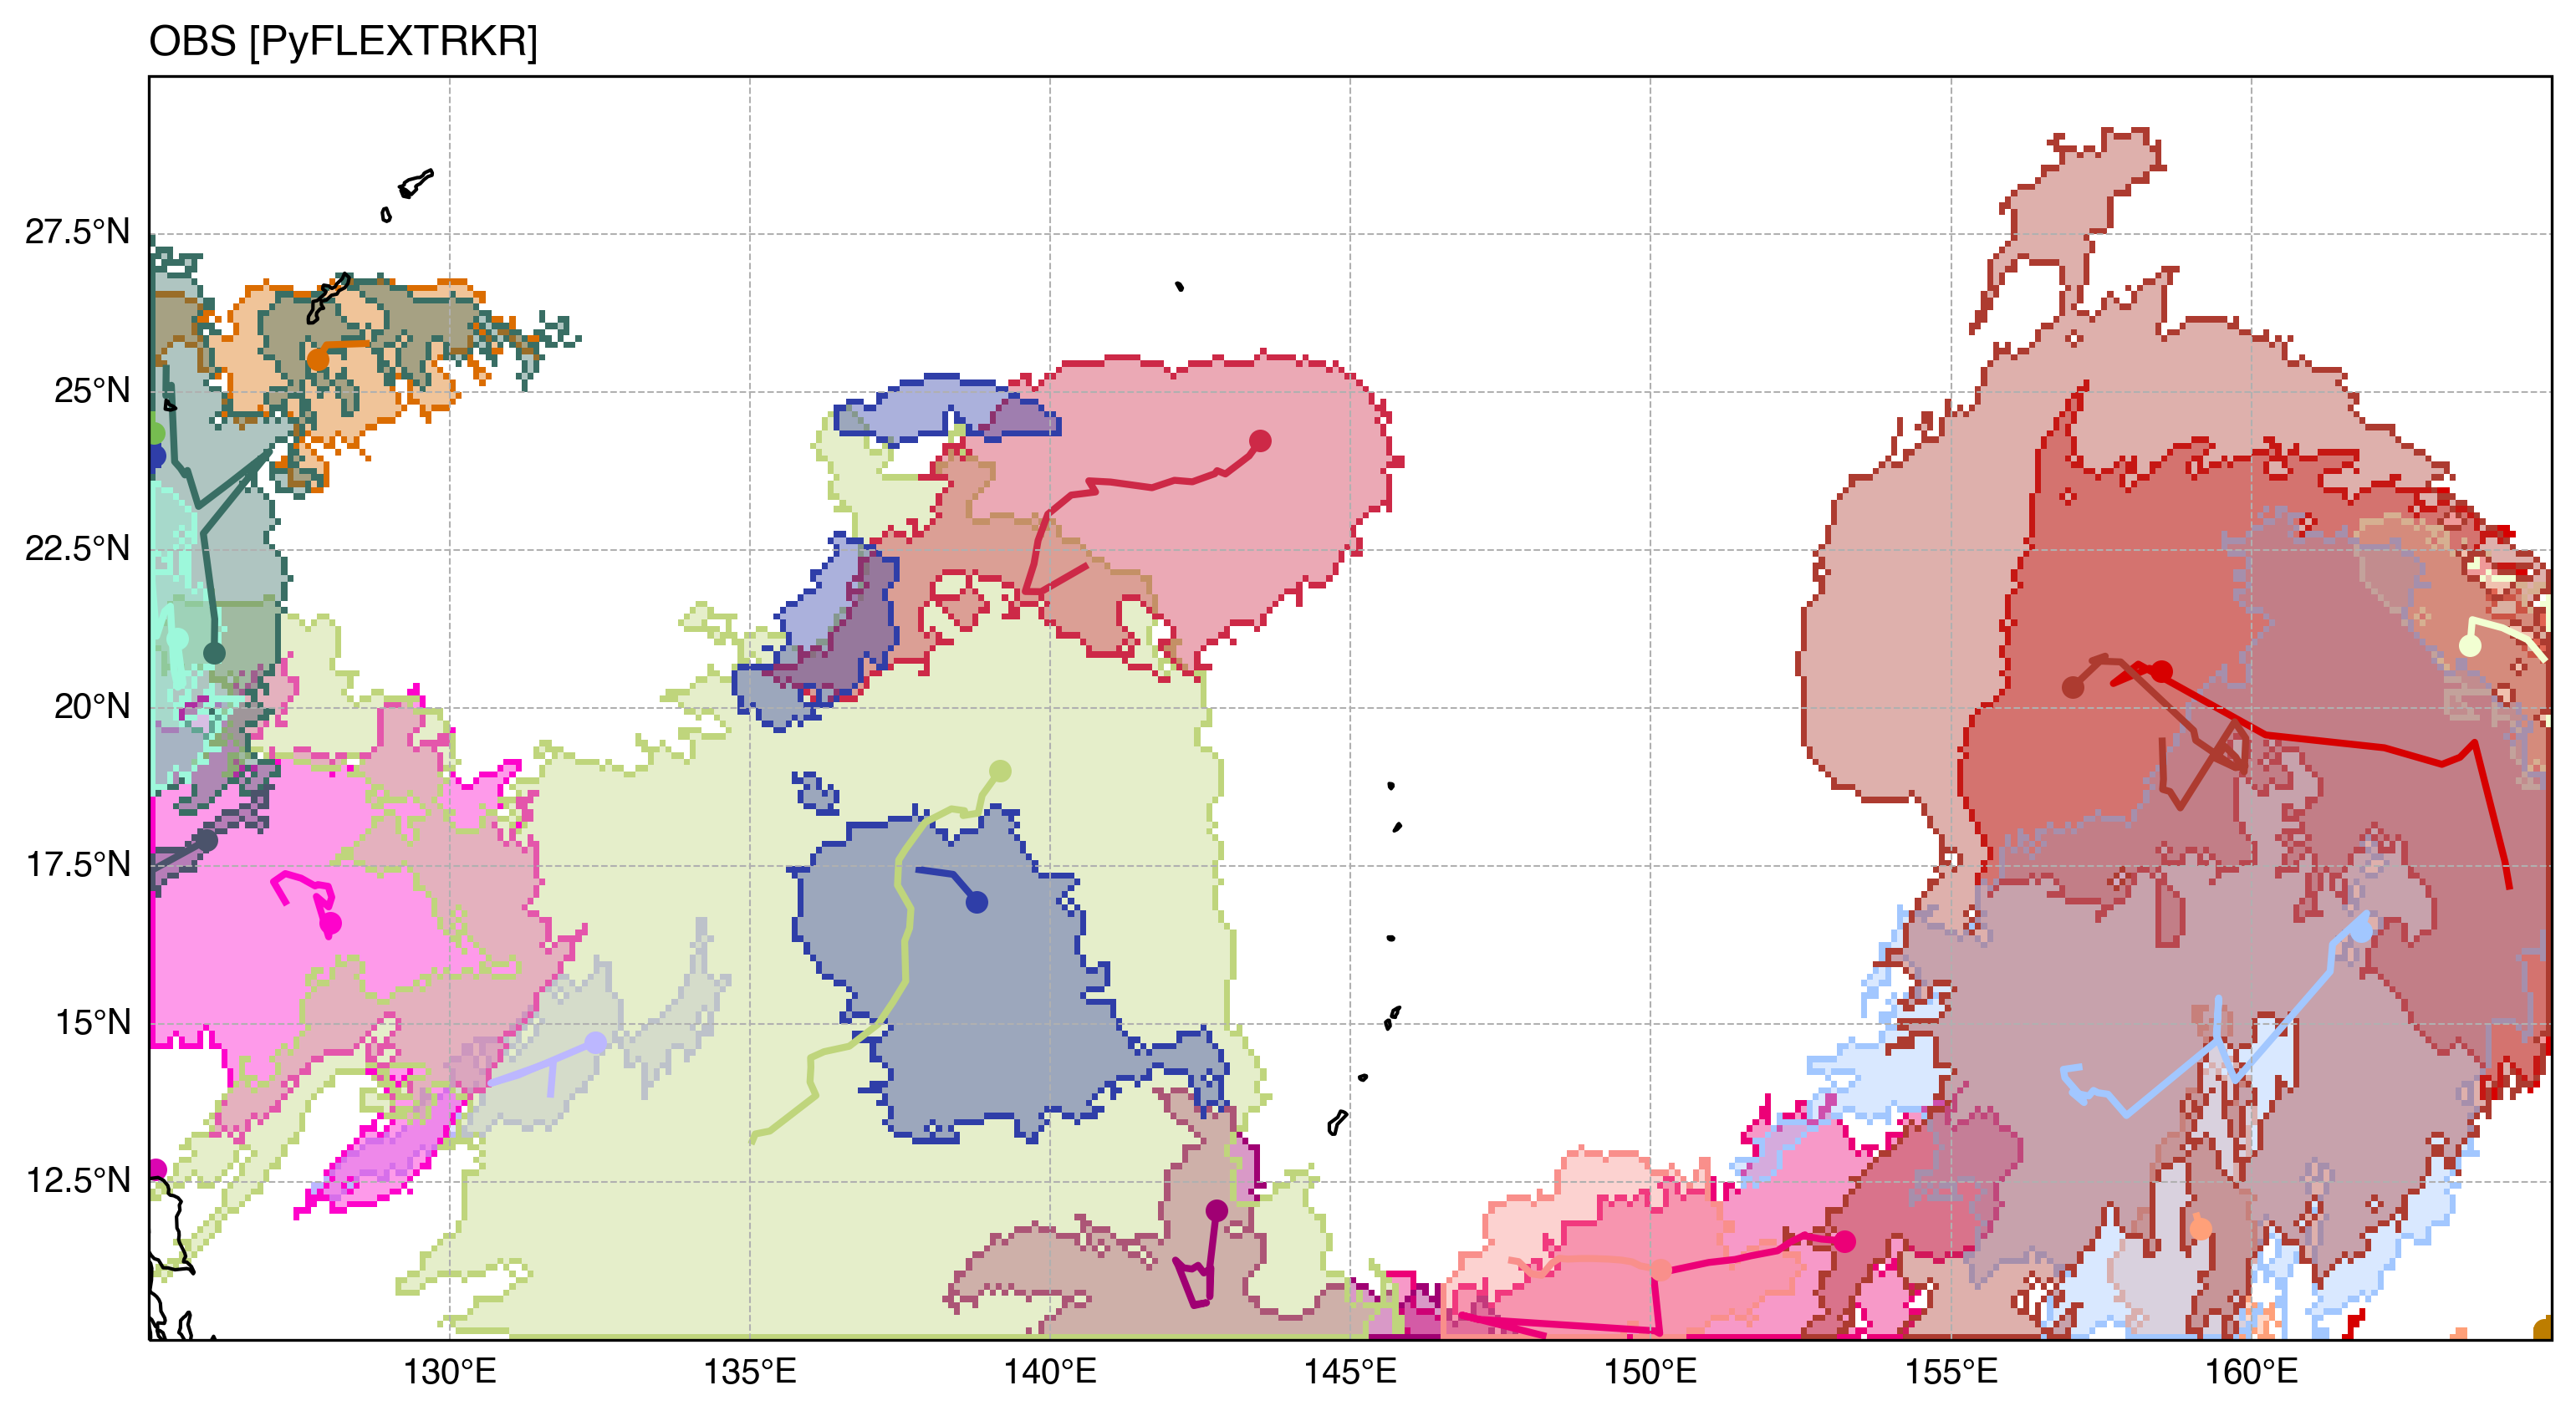

In [57]:
# Set up map projection
proj = ccrs.PlateCarree(central_longitude=180)
data_proj = ccrs.PlateCarree(central_longitude=0)
land = cfeature.NaturalEarthFeature('physical', 'land', map_resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', map_resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', map_resolution)

# Set up figure
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=figsize, dpi=dpi, facecolor='w')

# Set GridSpec for left (plot) and right (colorbars)
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[1, 0.1])
gs.update(wspace=0.05, left=0.05, right=0.95, top=0.92, bottom=0.08)
# Use GridSpecFromSubplotSpec for panel and colorbar
# gs_cb = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], height_ratios=[1], width_ratios=[0.01,0.01], wspace=5)
# ax1 = plt.subplot(gs[0], projection=proj)
# cax1 = plt.subplot(gs_cb[0])

ax1 = plt.subplot(gs[0,0], projection=proj)
# Map elements
ax1.set_extent(map_extent, crs=data_proj)
ax1.add_feature(land, facecolor='none', edgecolor=map_edgecolor, zorder=4)
if draw_border == True:
    ax1.add_feature(borders, edgecolor=map_edgecolor, facecolor='none', linewidth=0.8, zorder=4)
if draw_state == True:
    ax1.add_feature(states, edgecolor=map_edgecolor, facecolor='none', linewidth=0.8, zorder=4)
ax1.set_aspect('auto', adjustable=None)
# Gridlines
gl = ax1.gridlines(crs=data_proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lonv = None
latv = None
if (lonv is not None) & (latv is not None):
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title(titles, loc='left')

cmap = plt.get_cmap(cc.cm["glasbey"])
# Set up color levels
levels = np.arange(1, ntracks_pix+1, 1)
# Normalize the color map
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
# Get the color for each level (for track line plots)
lcolors = [cmap(norm(lev)) for lev in levels]

# Loop over each track
for ii in range(ntracks_pix):
    # Plot swath mask for the track
    _swath = mask_swath[ii,:,:].squeeze()
    _perim = mask_perim[ii,:,:].squeeze()
    Zm = np.ma.masked_where(_swath==0, _swath)
    pcm = ax1.pcolormesh(lon, lat, Zm, cmap=cmap, norm=norm, transform=data_proj, alpha=0.4)
    Zm = np.ma.masked_where(_perim==0, _perim)
    pcpr = ax1.pcolormesh(lon, lat, Zm, cmap=cmap, norm=norm, transform=data_proj, alpha=0.8)

    # Plot track path
    ax1.plot(tracks_lon[ii,:], tracks_lat[ii,:], color=lcolors[ii], lw=2, transform=data_proj, zorder=2)
    marker_style = dict(edgecolor=lcolors[ii], facecolor=lcolors[ii], linestyle='-', marker='o')
    # Find the first index that is not-NaN
    s_idx = np.argmax(~np.isnan(tracks_lon[ii,:]))
    ax1.scatter(tracks_lon[ii,s_idx], tracks_lat[ii,s_idx], s=30, zorder=2, transform=data_proj, **marker_style)
    
# fig.savefig(figname_mask, dpi=dpi, facecolor='w', bbox_inches='tight')

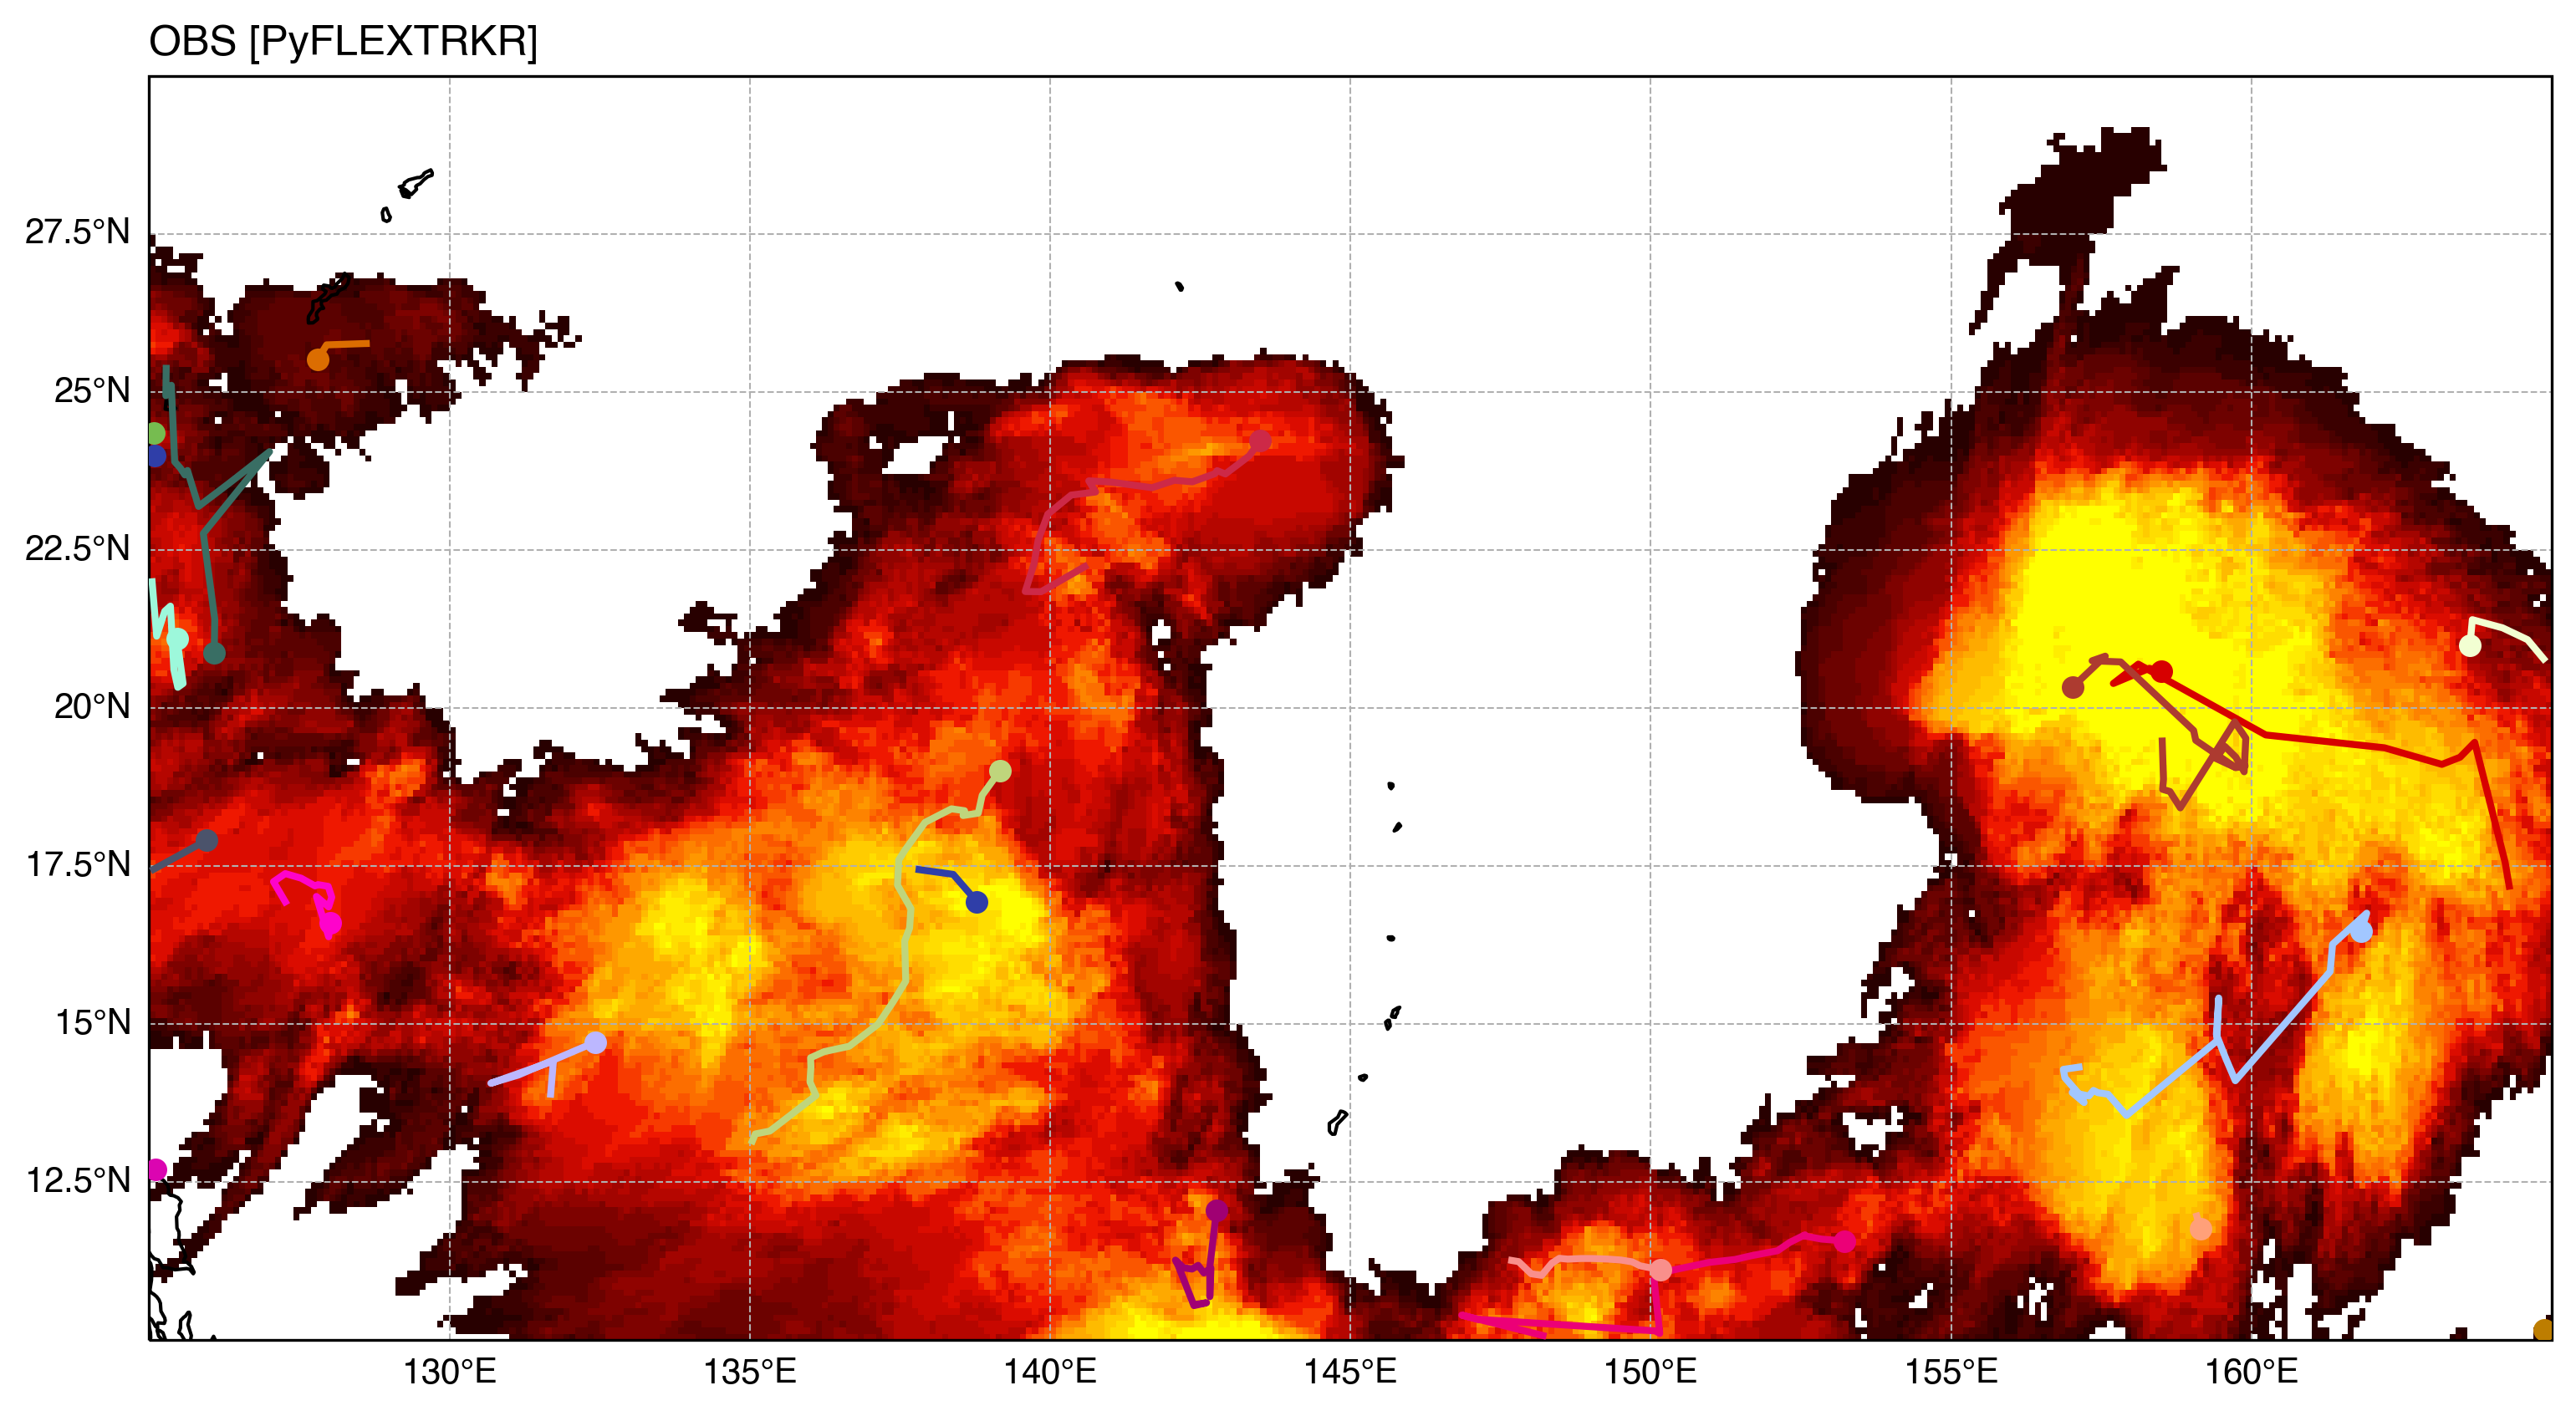

In [24]:
# Set up map projection
proj = ccrs.PlateCarree(central_longitude=180)
data_proj = ccrs.PlateCarree(central_longitude=0)
land = cfeature.NaturalEarthFeature('physical', 'land', map_resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', map_resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', map_resolution)

# Set up figure
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=figsize, dpi=dpi, facecolor='w')

# Set GridSpec for left (plot) and right (colorbars)
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[1, 0.1])
gs.update(wspace=0.05, left=0.05, right=0.95, top=0.92, bottom=0.08)
# Use GridSpecFromSubplotSpec for panel and colorbar
# gs_cb = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], height_ratios=[1], width_ratios=[0.01,0.01], wspace=5)
# ax1 = plt.subplot(gs[0], projection=proj)
# cax1 = plt.subplot(gs_cb[0])

ax1 = plt.subplot(gs[0,0], projection=proj)
# Map elements
ax1.set_extent(map_extent, crs=data_proj)
ax1.add_feature(land, facecolor='none', edgecolor=map_edgecolor, zorder=4)
if draw_border == True:
    ax1.add_feature(borders, edgecolor=map_edgecolor, facecolor='none', linewidth=0.8, zorder=4)
if draw_state == True:
    ax1.add_feature(states, edgecolor=map_edgecolor, facecolor='none', linewidth=0.8, zorder=4)
ax1.set_aspect('auto', adjustable=None)
# Gridlines
gl = ax1.gridlines(crs=data_proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False
lonv = None
latv = None
if (lonv is not None) & (latv is not None):
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()        
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title(titles, loc='left')

cmap = plt.get_cmap(cc.cm["glasbey"])
# Set up color levels
levels = np.arange(1, ntracks_pix+1, 1)
# Normalize the color map
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
# Get the color for each level (for track line plots)
lcolors = [cmap(norm(lev)) for lev in levels]

cmap = plt.get_cmap(cc.cm["CET_L4"])
# Set up color levels
levels = np.arange(0, ntime, 1)
# Normalize the color map
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

Zm = np.ma.masked_where(count_swath == 0, count_swath)
pcm = ax1.pcolormesh(lon, lat, Zm, cmap=cmap, norm=norm, transform=data_proj)

# Loop over each track
for ii in range(ntracks_pix):
    # # Plot swath mask for the track
    # _swath = mask_swath[ii,:,:].squeeze()
    # Zm = np.ma.masked_where(_swath==0, _swath)
    # pcm = ax1.pcolormesh(lon, lat, Zm, cmap=cmap, norm=norm, transform=data_proj, alpha=0.5)

    # Plot track path
    ax1.plot(tracks_lon[ii,:], tracks_lat[ii,:], color=lcolors[ii], lw=2, transform=data_proj, zorder=10)
    marker_style = dict(edgecolor=lcolors[ii], facecolor=lcolors[ii], linestyle='-', marker='o')
    # Find the first index that is not-NaN
    s_idx = np.argmax(~np.isnan(tracks_lon[ii,:]))
    ax1.scatter(tracks_lon[ii,s_idx], tracks_lat[ii,s_idx], s=30, zorder=10, transform=data_proj, **marker_style)
    
# fig.savefig(figname_count, dpi=dpi, facecolor='w', bbox_inches='tight')

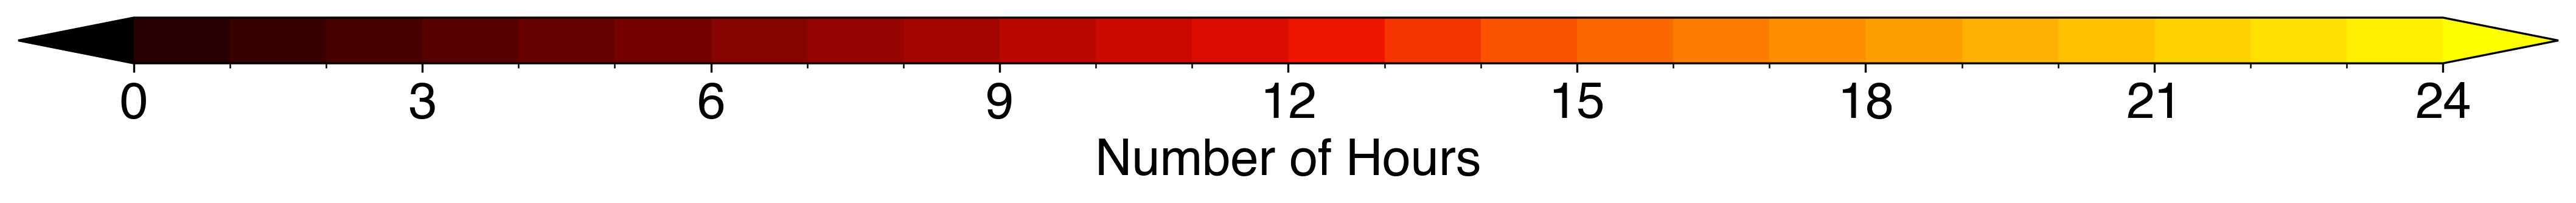

In [25]:
mpl.rcParams['font.size'] = fontsize*2
mpl.rcParams['font.family'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(14, 1), layout='constrained', dpi=300)

cmap = plt.get_cmap(cc.cm["CET_L4"])
levels = np.arange(0, ntime, 1)
cb_levels = np.arange(0, 24.1, 3)
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=cb_levels,
                     cax=ax, orientation='horizontal', label='Number of Hours')
# cbar.cmap.set_under('white')

# fig.savefig(figname_cb, dpi=dpi, facecolor='w', bbox_inches='tight')

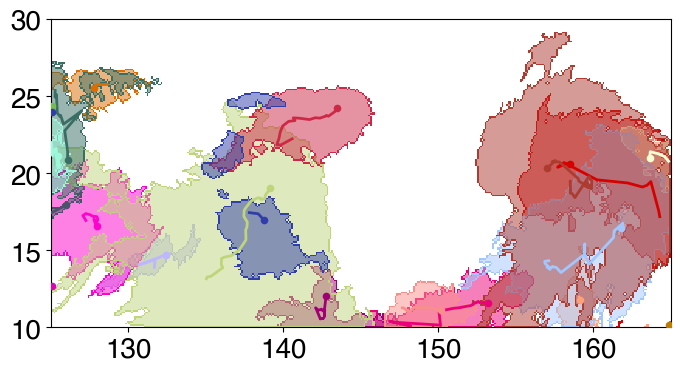

In [52]:
fig, ax = plt.subplots(1, 1, figsize=[8,4], dpi=100)

cmap = plt.get_cmap(cc.cm["glasbey"])
# Set up color levels
levels = np.arange(1, ntracks_pix+1, 1)
# Normalize the color map
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
# Get the color for each level (for track line plots)
lcolors = [cmap(norm(lev)) for lev in levels]

# Loop over each track
for ii in range(ntracks_pix):
    # Plot swath mask for the track
    _swath = mask_swath[ii,:,:].squeeze()
    _perim = mask_perim[ii,:,:].squeeze()
    Zm = np.ma.masked_where(_swath==0, _swath)
    pcm = ax.pcolormesh(lon, lat, Zm, cmap=cmap, norm=norm, alpha=0.5)
    Zm = np.ma.masked_where(_perim==0, _perim)
    pcpr = ax.pcolormesh(lon, lat, Zm, cmap=cmap, norm=norm, alpha=1)

    # Plot track path
    ax.plot(tracks_lon[ii,:], tracks_lat[ii,:], color=lcolors[ii], lw=2, zorder=10)
    marker_style = dict(edgecolor=lcolors[ii], facecolor=lcolors[ii], linestyle='-', marker='o')
    # Find the first index that is not-NaN
    s_idx = np.argmax(~np.isnan(tracks_lon[ii,:]))
    ax.scatter(tracks_lon[ii,s_idx], tracks_lat[ii,s_idx], s=20, zorder=10, **marker_style)
    # ax.scatter(tracks_lon[ii,0], tracks_lat[ii,0], s=20, zorder=10, **marker_style)
    
# fig.colorbar()

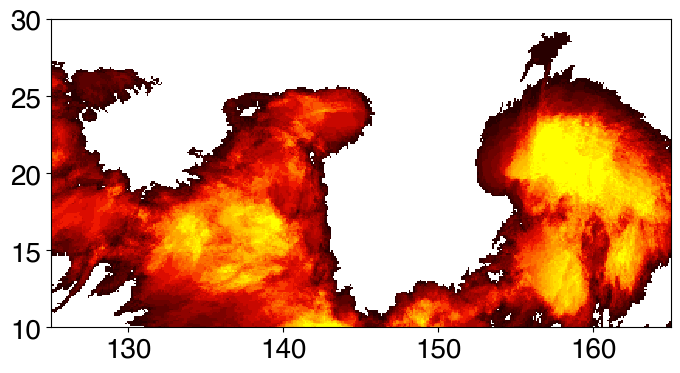

In [27]:
fig, ax = plt.subplots(1, 1, figsize=[8,4], dpi=100)

cmap = plt.get_cmap(cc.cm["CET_L4"])
# Set up color levels
levels = np.arange(0, ntime, 1)
# Normalize the color map
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

Zm = np.ma.masked_where(count_swath == 0, count_swath)
pcm = ax.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap)
# plt.colorbar(pcm)

In [28]:
# # Create a standalone horizontal colorbar
# fig, ax = plt.subplots(figsize=(20, 1))

# cmap = plt.get_cmap(cc.cm["CET_L4"])
# levels = np.arange(0, ntime, 1)
# # Normalize the color map
# norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
# cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal', ticks=levels, boundaries=levels)

# # Add labels to the colorbar
# cbar.set_label('Color Intensity')
# cbar.cmap.set_under('white')
# # cbar.set_ticklabels([f'{val:.2f}' for val in levels])

## Example plot
### No normalization of colormap, but the line plot colors do not match the swath masks

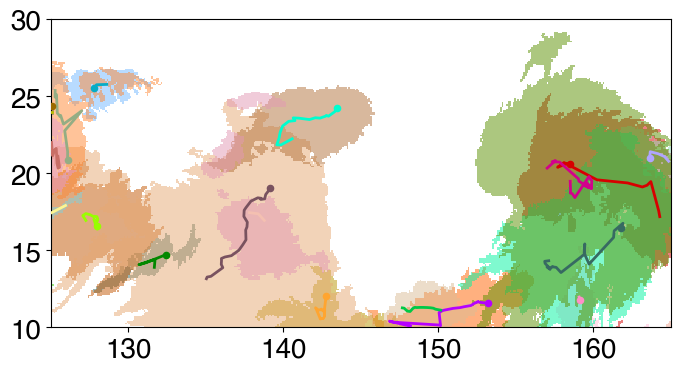

In [29]:
fig, ax = plt.subplots(1, 1, figsize=[8,4], dpi=100)

cmap = plt.get_cmap(cc.cm["glasbey_light"]) 
levels = np.arange(1, ntracks_pix+1, 1)
# norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
# colors = [cmap(norm(lev)) for lev in levels]
colors = [cmap(i) for i in range(ntracks_pix)]

# colors
for ii in range(ntracks_pix):
    _swath = mask_swath[ii,:,:].squeeze()
    Zm = np.ma.masked_where(_swath==0, _swath)
    pcm = ax.pcolormesh(lon, lat, Zm, cmap=cmap, vmin=1, vmax=ntracks_pix+1, alpha=0.5)
    # Get the color value for the line
    lcolor = pcm.cmap(ii)
    # print(lcolor, colors[ii])
    # lcolor = colors[ii]
    # Plot track path
    ax.plot(tracks_lon[ii,:], tracks_lat[ii,:], color=lcolor, lw=2, zorder=10)
    marker_style = dict(edgecolor=lcolor, facecolor=lcolor, linestyle='-', marker='o')
    ax.scatter(tracks_lon[ii,0], tracks_lat[ii,0], s=20, zorder=10, **marker_style)

In [30]:
# ii = 4
# cmap = plt.get_cmap(cc.cm["glasbey_light"])
# _swath = mask_swath[ii,:,:].squeeze()
# Zm = np.ma.masked_where(_swath==0, _swath)
# pcm = plt.pcolormesh(lon, lat, Zm, cmap=cmap, vmin=1, vmax=ntracks_pix+1, alpha=0.5)
# lcolor = cmap(ii)
# plt.plot(tracks_lon[ii,:], tracks_lat[ii,:], color=lcolor, lw=2, zorder=10)